In [1]:
!gdown 1H_bjIftpkfhl2glUSOemRZieRF9gtro6

Downloading...
From: https://drive.google.com/uc?id=1H_bjIftpkfhl2glUSOemRZieRF9gtro6
To: /content/news_dataset.json
100% 2.23M/2.23M [00:00<00:00, 140MB/s]


In [5]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [3]:
df = pd.read_json("/content/news_dataset.json")
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [4]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

# Handle class imbalance

,text,category
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
5,Trump Pays Penalty For Ethically Questionable ...,BUSINESS
7,9 Tips for Making Your Blog Better in 2015 New...,BUSINESS
10,This Is The First 10 Years Of Your Career You ...,BUSINESS
...,...,...
12682,"56 Successful Business Leaders, Including Repu...",BUSINESS
12685,Nearly Two-Thirds Of Marketers Are Not Giving ...,BUSINESS
12687,"Get Even I was in debt. Serious debt. The ""how...",BUSINESS
12688,Basic Premise of Social Integration Easy for u...,BUSINESS


In [8]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class


df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [9]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

In [10]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map(target)

In [12]:
df_balanced.head()

,text,category,category_num
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


# Build a model with original text (no pre processing)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [14]:
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [15]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

# Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model

In [16]:
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



# Attempt 2 : Use 1-gram and bigrams

In [17]:
clf = Pipeline([
    ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



# Attempt 3 : Use 1-gram to trigrams

In [18]:
clf = Pipeline([
    ('vectorizer_1_3_grams', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



# Use text pre-processing to remove stop words, punctuations and apply lemmatization

In [19]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess) 

In [20]:
df_balanced.head()

,text,category,category_num,preprocessed_txt
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,GCC Business Leaders remain Confident Face Reg...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review employee wake morning love impor...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment ceo FreshBooks Talks give build...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,Leverage intuition decision making feel safe r...


# Build a model with pre processed text

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [22]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       276
           1       0.92      0.82      0.87       277
           2       0.83      0.92      0.87       276
           3       0.90      0.81      0.85       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



# Plot confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[243,   8,  17,   8],
       [ 10, 228,  29,  10],
       [ 15,   2, 253,   6],
       [ 36,   9,   7, 224]])

Text(95.72222222222221, 0.5, 'Truth')

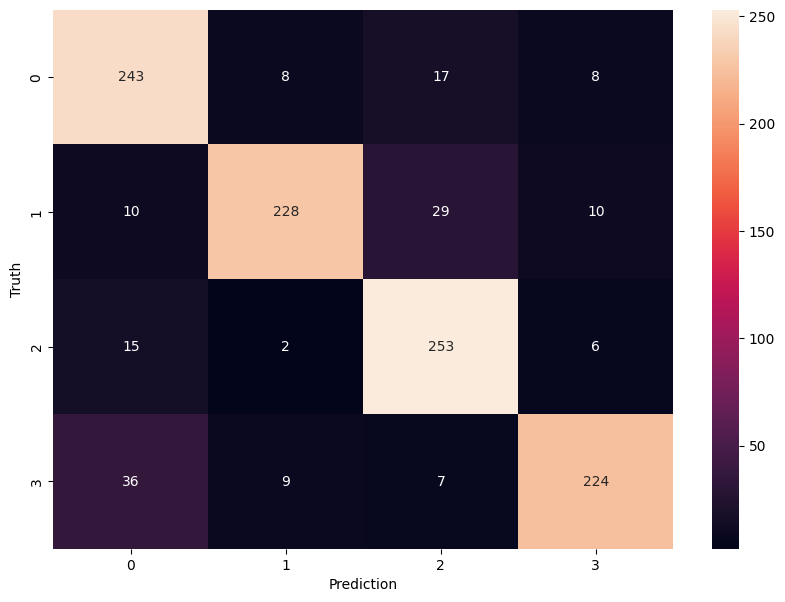

In [24]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

link --> https://colab.research.google.com/drive/1J99tFZ4H4Dfr_APqrbKSNSydf8W4DOL4?usp=sharing